<div class="alert alert-info">
    
➡️ Make sure that you have read the **[rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins)** and the **[policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating)** before starting with this lab.

➡️ Make sure you fill in any cells (and _only_ those cells) that say **`YOUR CODE HERE`** or **YOUR ANSWER HERE**, and do _not_ modify any of the other cells.

➡️ **Before you submit your lab, make sure everything runs as expected.** For this, _restart the kernel_ and _run all cells_ from top to bottom. In Jupyter Notebook version 7 or higher, you can do this via "Run$\rightarrow$Restart Kernel and Run All Cells..." in the menu (or the "⏩" button in the toolbar).

</div>

# L3: Text clustering and topic modelling

Text clustering groups documents in such a way that documents within a group are more &lsquo;similar&rsquo; to other documents in the cluster than to documents not in the cluster. The exact definition of what &lsquo;similar&rsquo; means in this context varies across applications and clustering algorithms.

In this lab you will experiment with both hard and soft clustering techniques. More specifically, in the first part you will be using the $k$-means algorithm, and in the second part you will be using a topic model based on the Latent Dirichlet Allocation (LDA).

In [1]:
# Define some helper functions that are used in this notebook

%matplotlib inline
from IPython.display import display, HTML

def success():
    display(HTML('<div class="alert alert-success"><strong>Solution appears correct!</strong></div>'))

## Hard clustering data set

The raw data for the hard clustering part of this lab is a collection of product reviews. We have preprocessed the data by tokenization and lowercasing.

In [2]:
import pandas as pd
import bz2

with bz2.open('reviews.json.bz2') as source:
    df = pd.read_json(source)

When you inspect the data frame, you can see that there are three labelled columns: `category` (the product category), `sentiment` (whether the product review was classified as &lsquo;positive&rsquo; or &lsquo;negative&rsquo; towards the product), and `text` (the space-separated text of the review).

In [3]:
df.head()

,category,sentiment,text
0,music,neg,i bought this album because i loved the title ...
1,music,neg,i was misled and thought i was buying the enti...
2,books,neg,"i have introduced many of my ell , high school..."
3,books,pos,anything you purchase in the left behind serie...
4,dvd,pos,"i loved these movies , and i cant wiat for the..."


## Problem 1: K-means clustering

Your first task is to cluster the product review data using a tf–idf vectorizer and a $k$-means clusterer.

### Task 1.1

Start by doing the vectorization. In connection with vectorization, you should also filter out standard English stop words. While you could use [spaCy](https://spacy.io/) for this task, here it suffices to use the word list implemented in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

After running the following cell:
- `vectorizer` should contain the vectorizer fitted on `df['text']`
- `reviews` should contain the vectorized `df['text']`

In [4]:
#vectorizer, reviews = ..., ...

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
reviews = vectorizer.fit_transform(df['text'])

# YOUR CODE HERE
#raise NotImplementedError()

#### 🤞 Test your code

If you used the English stop word list from scikit-learn, then the resulting vocabulary should have 46,619 entries.  You can check this by running the following code cell:

In [5]:
"""Check that the vectorized text column has the right dimensions."""

assert reviews.shape == (11914, 46619), f"Wrong dimensions: {reviews.shape}"
success()

### Task 1.2

Next, cluster the vectorized data. Before doing so, you should read the documentation of the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, which is scikit-learn&rsquo;s implementation of the $k$-means algorithm. As you can see, this class has several parameters that you can tweak. For now, the only parameter that you will have to set is the number of clusters. Start with $k=3$.

**Tip:** Training $k$-means models will take some time. To speed things up, you can use the `n_init` parameter to control the number of times that the clustering is re-computed with different initial values. The default value for this parameter is 10; here and in the rest of this lab, you may want to set this to a lower value, or simply to "auto".

In [6]:
from sklearn.cluster import KMeans

def fit_kmeans(data, n_clusters):
    """Fit a k-means classifier to some data.

    Arguments:
        data: The vectorized data to train the classifier on.
        n_clusters (int): The number of clusters.

    Returns:
        The trained k-means classifier.
    """
    # YOUR CODE HERE

    kmeans = KMeans(n_clusters, random_state=0, n_init="auto").fit(data)

    return kmeans
    
    #raise NotImplementedError()

To sanity-check your clustering, create a bar plot with the number of documents per cluster.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cluster_size(kmeans):
    """Produce & display a bar plot with the number of documents per cluster.

    Arguments:
        kmeans: The trained k-means classifier.
    """
    # YOUR CODE HERE
    # Getting each document's cluster label
    cluster_labels = kmeans.labels_

    #Count the number of documents in each cluster
    unique_labels, doc_counts = np.unique(cluster_labels, return_counts=True)

    # Plot the bar chart
    plt.bar(unique_labels, doc_counts, align='center',color = ['lightblue', 'lightgreen', 'salmon'])
    plt.xticks(unique_labels)
    plt.xlabel('Cluster Label')
    plt.ylabel('Number of Documents')
    plt.title('Number of Documents per Cluster')
    plt.show()
    #raise NotImplementedError()

#### 🤞 Test your code

The following cell shows how your code should run.  The output of the cell should be the bar plot of the cluster sizes.  Note that sizes may vary considerable between clusters and among different random seeds, so there is no single “correct” output here!

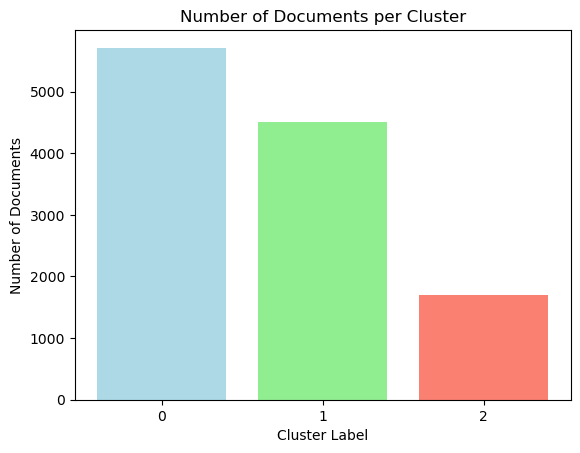

In [8]:
kmeans = fit_kmeans(reviews, 3)
plot_cluster_size(kmeans)

## Problem 2: Summarize clusters

Once you have a clustering, you can try to see whether it is meaningful. One useful technique in that context is to generate a **summary** for each cluster by extracting the $n$ highest-weighted terms from the centroid of each cluster. Your next task is to implement this approach.

(Hint: You will need to figure out how to use the vectorizer to convert indices back into the terms they represent.)

In [9]:
import numpy as np

def compute_cluster_summaries(kmeans, vectorizer, top_n):
    """Compute the top_n highest-weighted terms from the centroid of each cluster.

    Arguments:
        kmeans: The trained k-means classifier.
        vectorizer: The fitted vectorizer; needed to obtain the actual terms
                    belonging to the items in the cluster.
        top_n: The number of terms to return for each cluster.

    Returns:
        A list of length k, where k is the number of clusters. Each item in the list
        should be a list of length `top_n` with the highest-weighted terms from that
        cluster.  Example:
          [["first", "foo", ...], ["second", "bar", ...], ["third", "baz", ...]]
    """
    # YOUR CODE HERE

    # Extracting the cluster centroids from kmeans
    centroids = kmeans.cluster_centers_

    # Extracting the feature terms from the vectorizer
    feature_terms = vectorizer.get_feature_names_out()

    # An empty list to store the summary for each cluster
    cluster_summary = []

    # Iterate through each cluster
    for centre in centroids:
        # Getting the indices of the top-n highest-weighted terms
        top_n_indices = centre.argsort()[-top_n:][::-1]

        # Getting the original terms from the vectorizer
        top_terms = [feature_terms[i] for i in top_n_indices]

        # Appending the top_terms to the summary
        cluster_summary.append(top_terms)

    return cluster_summary
   # raise NotImplementedError()

### 🤞 Test your code

The following cell runs your code with `top_n=10`, checks that the returned lists have the expected dimensions, and prints the summaries:

In [10]:
summaries = compute_cluster_summaries(kmeans, vectorizer, 10)

assert isinstance(summaries, list) and len(summaries) == 3, "Return value should be a list of length 3 (the number of clusters)"
assert all(len(summary) == 10 for summary in summaries), "Each list should contain exactly 10 terms"
assert all(isinstance(term, str) for s in summaries for term in s), "Each list should contain strings"
success()

for idx, terms in enumerate(summaries):
    print(f"Cluster {idx}: {', '.join(terms)}")

Cluster 0: book, movie, like, film, read, good, just, great, really, did
Cluster 1: camera, product, use, lens, software, great, pictures, easy, does, good
Cluster 2: album, cd, music, songs, quot, song, like, just, great, good


Once you have computed the cluster summaries, take a minute to reflect on their quality. Is it clear what the reviews in a given cluster are about? Do the cluster summaries contain any unexpected terms?

The summaries for each cluster of reviews show that people are talking about specific things in their reviews. Cluster-0 seems to be about books and movies. People are saying positive things like "good" and "great" about the books and movies they liked. Cluster-1 is about products. People are using words like "camera" and "product" and saying positive things like "great" and "easy" about them. Group-2 is related to music or albums. People are mentioning terms like "album", "song" and "music" and expressing positive feelings like "great" and "good" about the music or albums they enjoyed. No unexpected terms are present in the summaries, indicating that the algorithm has grouped the similar reviews together.




## Problem 3: Compare clusterings using the Rand index

In some scenarios, you may have gold-standard class labels available for at least a subset of your documents. In these cases you can compute the **Rand index** of a clustering, and use this measure to compare the quality of different clusterings.

To compute the Rand index, we view a clustering as a binary classifier on (unordered) pairs of documents. The classifier predicts &lsquo;positive&rsquo; if and only if the two documents belong to the same cluster. The (non-normalized) Rand index of the clustering is the accuracy of this classifier relative to a reference in which a document pair belongs to the &lsquo;positive&rsquo; class if and only if the two documents in the pair have the same gold-standard class label.

### Task 3.1

Implement a function that computes the Rand index “manually”, i.e., _without_ importing an external function from a library.

In [11]:
def rand_index(pred_labels, gold_labels):
    """Compute the Rand index.

    Arguments:
        pred_labels: The predicted labels.
        gold_labels: The gold-standard labels.

    Returns:
        The Rand index (a single number).
    """
    # YOUR CODE HERE

    # Total number of pairs
    total_no_pairs = ((len(pred_labels) - 1)*len(pred_labels)) // 2

    # Initialize a variable to count agreeing pairs
    agreeing_pairs = 0
    
    # Iterating over all pairs of documents
    for i in range(len(pred_labels)):
        for j in range(i + 1, len(pred_labels)):
            
            # Check if both the documents belong to same predicted cluster
            same_cluster = 1 if pred_labels[i] == pred_labels[j] else 0

            # Check if both the documents belong to same gold-standard cluster
            gs_label = 1 if gold_labels[i] == gold_labels[j] else 0

            # Update counts
            if same_cluster == gs_label:
                agreeing_pairs += 1
    # Calculate the Rand index
    rand_index = agreeing_pairs / total_no_pairs

    return rand_index

    #raise NotImplementedError()

#### 🤞 Test your code

The following cell computes the Rand index on some “toy” examples to check if your implementation is correct:

In [12]:
assert rand_index([0, 0, 0], [0, 1, 2]) == 0.0
assert rand_index([1, 2, 0], [0, 1, 2]) == 1.0
assert rand_index([1, 2, 1, 2], [0, 1, 2, 2]) == 0.5
success()

### Task 3.2

Using your implementation of the Rand index, compare the performance of different k-means clusters with $k \in \{1,2,3,5,7\}$ clusters. As your evaluation data, use the first 500 documents from the original data set along with their gold-standard categories (from the `category` column).

Your implementation should print the computed Rand index for each of the values for $k$.

In [13]:
# YOUR CODE HERE

# Considering only first 500 documents
new_df = df.head(500)

#Vectorizing the first 500 documents 
new_reviews = vectorizer.fit_transform(new_df['text'])

#Getting gold-standard categories
gs_cat = df["category"].head(500).tolist()

num_of_clusters = [1, 2, 3, 5, 7]

# To compute Rand Index of each values of k
for k in num_of_clusters:
    
    # Fit k-means with the current value of k
    kmeans = KMeans(n_clusters=k, random_state=0,n_init="auto").fit(new_reviews)
    
    # Predicted cluster labels
    predicted_clusters = kmeans.labels_

    # Computing the Rand index
    rand_ind = rand_index(predicted_clusters, gs_cat)

    # Print Rand Index for each value of k
    print(f"For k = {k}, Rand Index: {rand_ind}")
#raise NotImplementedError()

For k = 1, Rand Index: 0.16626052104208416
For k = 2, Rand Index: 0.6084569138276553
For k = 3, Rand Index: 0.6735711422845692
For k = 5, Rand Index: 0.7655150300601202
For k = 7, Rand Index: 0.8095310621242485


Give a brief summary of your results!

When we set only one cluster (k=1), the clustering is not very accurate, indicated by a low Rand Index. As we increase the number of clusters (k=2, 3, 5, 7), the algorithm did a better job in forming its clusters with the actual labels of the documents. The highest Rand Index is achieved when using seven clusters (k=7), suggesting that this configuration captures the different themes or topics in the documents most accurately.s

## Problem 4: Train a topic model

### Data set

The data set for the topic modelling part of this lab is the collection of all [State of the Union](https://en.wikipedia.org/wiki/State_of_the_Union) addresses from the years 1975–2000. These speeches come as a single text file with one sentence per line. The following code cell prints the first 5 lines from the data file:

In [14]:
from itertools import islice

with open('sotu_1975_2000.txt') as source:
    # Print the first 5 lines only
    for line in islice(source, 5):
        print(line.rstrip())

mr speaker mr vice president members of the 94th congress and distinguished guests
twenty six years ago a freshman congressman a young fellow with lots of idealism who was out to change the world stood before sam rayburn in the well of the house and solemnly swore to the same oath that all of you took yesterday an unforgettable experience and i congratulate you all
two days later that same freshman stood at the back of this great chamber over there someplace as president truman all charged up by his single handed election victory reported as the constitution requires on the state of the union
when the bipartisan applause stopped president truman said i am happy to report to this 81st congress that the state of the union is good our nation is better able than ever before to meet the needs of the american people and to give them their fair chance in the pursuit of happiness it is foremost among the nations of the world in the search for peace
today that freshman member from michigan stan

Take a few minutes to think about what topics you would expect in this data set.

The data contains speeches from the State of the Union between 1975 and 2000. It's probably going to talk about various things related to the United States during that time. This could include talks about the government's performance, international relations, the economy, social issues, and what the President thinks is important. They might discuss specific things like healthcare, education, safety, transparency, and taking care of the environment. In short, we can expect to hear about a lot of different important topics that the U.S. government was focused on during these years.

### Task 4.1

Your first task on the topic modelling data is to train an LDA model. For this task you will be using [spaCy](https://spacy.io/) and the [gensim](https://radimrehurek.com/gensim/) topic modelling library.

Start by preprocessing the data using spaCy.  Filter out stop words, non-alphabetic tokens, and tokens less than 3 characters in length. Store the documents as a nested list where the first level of nesting corresponds to the sentences and the second level corresponds to the tokens in each sentence.

In [15]:
import spacy
nlp = spacy.load("en_core_web_sm")

def load_and_preprocess_documents(filename="sotu_1975_2000.txt"):
    """Load and preprocess all documents in the given file.

    The preprocessing must filter out stop words, non-alphabetic tokens,
    and tokens less than 3 characters in length.

    Returns:
        A list of length n, where n is the number of documents.
        Each item in the list should be a list of tokens in the given
        document, after preprocessing.
    """
    # YOUR CODE HERE
    
    # An empty list to store preprocessed documents
    preproc_documents = []

    with open(filename) as source:
        # Iterate through each line in the file
        for line in source:
            # Tokenization
            doc = nlp(line.rstrip())

            # Removing stop words, non-alphabetic tokens, and tokens less than 3 characters
            tokens = [token.text for token in doc if not token.is_stop and token.is_alpha and len(token.text)>=3]
                        
            # Append the preprocessed tokens 
            preproc_documents.append(tokens)

    return preproc_documents
    #raise NotImplementedError()

#### 🤞 Test your code

Test your preprocessing by running the following cell. It will output the tokens (after preprocessing) for an example document and compare them against the expected output.

In [16]:
documents = load_and_preprocess_documents()

assert len(documents) == 2898, "The number of documents should equal the number of lines in the input file"
print(f"document  0 after preprocessing: {' '.join(documents[0])}")
assert " ".join(documents[0]) == "speaker vice president members congress distinguished guests"
print(f"document 42 after preprocessing: {' '.join(documents[42])}")
assert " ".join(documents[42]) == "reduce oil imports million barrels day end year million barrels day end", "The output for document 42 does not appear to be correct"
success()

document  0 after preprocessing: speaker vice president members congress distinguished guests
document 42 after preprocessing: reduce oil imports million barrels day end year million barrels day end


### Task 4.2

Now that you have the list of documents, skim the section [Pre-process and vectorize the documents](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents) of the gensim documentation to learn how to create the dictionary and the vectorized corpus representation required by gensim. _(Note that you cannot use the standard scikit-learn pipeline in this case.)_ Then, write code to train an [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) for $k=10$ topics, and using default values for all other parameters.

In [17]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

def train_lda_model(documents, num_topics, passes=1):
    """Create and train an LDA model.

    Arguments:
        documents: The preprocessed documents, as produced in Task 4.1.
        num_topics: The number of topics to generate.
        passes: The number of training passes. Defaults to 1; you will need
                this later for Task 5.

    Returns:
        The trained LDA model.
    """
    # YOUR CODE HERE

    #Reference: https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents
    
    # Create a Gensim dictionary 
    dictionary = Dictionary(documents)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=20, no_above=0.5)

    # Bag-of-words representation of the documents
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=passes)
    

    return lda_model
    #raise NotImplementedError()

#### 🤞 Test your code

Run the following cell to test your code and print the topics:

In [18]:
model = train_lda_model(documents, 10)
model.print_topics()

[(0,
  '0.021*"world" + 0.020*"peace" + 0.020*"congress" + 0.015*"america" + 0.015*"years" + 0.014*"new" + 0.012*"people" + 0.012*"democracy" + 0.011*"freedom" + 0.010*"year"'),
 (1,
  '0.023*"year" + 0.015*"weapons" + 0.014*"budget" + 0.013*"federal" + 0.012*"government" + 0.011*"air" + 0.011*"years" + 0.010*"people" + 0.010*"rural" + 0.010*"growth"'),
 (2,
  '0.026*"people" + 0.020*"know" + 0.019*"want" + 0.017*"world" + 0.016*"help" + 0.012*"government" + 0.012*"nuclear" + 0.011*"years" + 0.010*"like" + 0.010*"new"'),
 (3,
  '0.017*"let" + 0.016*"america" + 0.016*"people" + 0.016*"challenge" + 0.014*"new" + 0.013*"welfare" + 0.013*"time" + 0.012*"years" + 0.012*"work" + 0.011*"tonight"'),
 (4,
  '0.023*"america" + 0.021*"american" + 0.018*"world" + 0.017*"people" + 0.015*"americans" + 0.014*"year" + 0.013*"let" + 0.013*"congress" + 0.010*"nation" + 0.009*"security"'),
 (5,
  '0.028*"new" + 0.023*"work" + 0.021*"america" + 0.014*"people" + 0.014*"children" + 0.012*"support" + 0.011*"

Inspect the topics. Can you &lsquo;label&rsquo; each topic with a short description of what it is about? Do the topics match your expectations?

The topics we can expect from the trained LDA model are:

Topic 0: Budget on controllig drug abuse.   
Topic 1: Budget considerations, and national matters involving people and the American context  
Topic 2: America's global role, world affairs, peace and economic considerations  
Topic 3: Human welfare   
Topic 4: Issues concerning children, parenting and community support  
Topic 5: Social issues, security and government involvement  
Topic 6: About new developments in the aspects of schools, children's education, and role of teachers.  
Topic 7: Discussions about new developments, the role of women and energy related issues  
Topic 8: About the role of country and people in global aspect  
Topic 9: Discussions about the passing years, Congress, healthcare, children, workforce and college education.

## Problem 5: Monitor a topic model for convergence

When learning an LDA model, it is important to make sure that the training algorithm has converged to a stable posterior distribution. One way to do so is to plot, after each training epochs (or &lsquo;pass&rsquo;, in gensim parlance) the log likelihood of the training data under the posterior. Your last task in this lab is to create such a plot and, based on this, to suggest an appropriate number of epochs.

To collect information about the posterior likelihood after each pass, we need to enable the logging facilities of gensim. Once this is done, gensim will add various diagnostics to a log file `gensim.log`.

In [19]:
import logging

logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

def clear_logfile():
    # To empty the log file
    with open("gensim.log", "w"):
        pass

The following function will parse the generated logfile and return the list of log likelihoods.

In [20]:
import re

def parse_logfile():
    """Parse gensim.log to extract the log-likelihood scores.

    Returns:
        A list of log-likelihood scores.
    """
    matcher = re.compile('(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

Here's an example how to run it — note that we call `clear_logfile()` to empty the logfile before training the model. If your code from problem 4 was correct, the result should be a list with a single log-likehoodscore, since we are doing a single training pass:

In [21]:
clear_logfile()
model = train_lda_model(documents, 10, passes=1)
likelihoods = parse_logfile()
print(likelihoods)

[-6.89]


### Task 5.1

Your task now is to write re-train your LDA model for 50&nbsp;passes, retrieve the list of log likelihoods, and create a plot from this data.

In [22]:
def plot_likelihoods(likelihoods):
    """Produce & display a plot of the log-likelihood scores during training.

    Arguments:
        likelihoods: A list of scores, as returned by `parse_logfile()`.
    """
    # YOUR CODE HERE
    plt.plot(range(1, len(likelihoods) + 1), likelihoods)
    plt.title('Log-Likelihood scores ruring training')
    plt.xlabel('Number of Passes')
    plt.ylabel('Log-Likelihood Score')
    plt.grid(True)
    plt.show()
    #raise NotImplementedError()

#### 🤞 Test your code

Once you've implemented the plotting function, you can run the LDA model with 50 passes (this will take a moment) and plot the resulting scores:

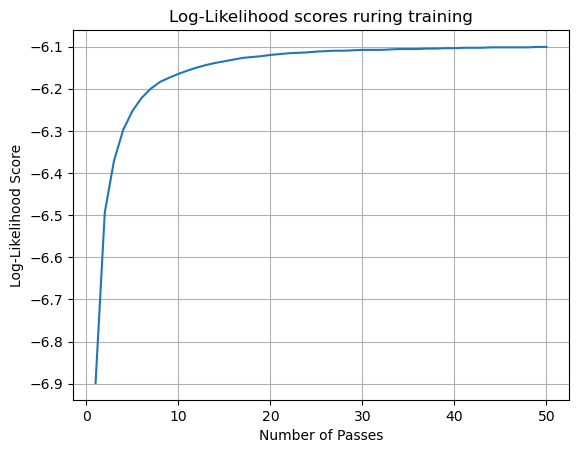

In [23]:
clear_logfile()
model = train_lda_model(documents, 10, passes=50)
likelihoods = parse_logfile()
plot_likelihoods(likelihoods)

In [24]:
# To choose the reasonable number of passes
print(f"The Reasonable number of passes: {np.argmax(likelihoods)}")

The Reasonable number of passes: 48


### Task 5.2

How do you interpret the plot you produced in Task 5.1? Based on the plot, what would be a reasonable choice for the number of passes? Retrain your LDA model with that number and re-inspect the topics it finds.

In [25]:
# YOUR CODE HERE
model_opt = train_lda_model(documents, 49)
model_opt.print_topics()
#raise NotImplementedError()

[(45,
  '0.025*"world" + 0.024*"wage" + 0.020*"people" + 0.017*"nations" + 0.017*"nuclear" + 0.016*"government" + 0.016*"know" + 0.015*"going" + 0.014*"weapons" + 0.014*"peace"'),
 (30,
  '0.036*"america" + 0.031*"middle" + 0.022*"peace" + 0.020*"new" + 0.020*"family" + 0.020*"east" + 0.016*"americans" + 0.015*"american" + 0.014*"generation" + 0.013*"people"'),
 (14,
  '0.056*"china" + 0.028*"economic" + 0.021*"people" + 0.021*"rural" + 0.021*"support" + 0.016*"opportunity" + 0.016*"american" + 0.015*"half" + 0.015*"world" + 0.015*"america"'),
 (46,
  '0.033*"thank" + 0.022*"years" + 0.021*"security" + 0.021*"help" + 0.020*"support" + 0.018*"budget" + 0.016*"america" + 0.014*"people" + 0.014*"especially" + 0.014*"defense"'),
 (47,
  '0.027*"care" + 0.021*"stop" + 0.020*"tax" + 0.019*"child" + 0.019*"research" + 0.016*"investments" + 0.015*"parents" + 0.013*"world" + 0.013*"percent" + 0.012*"wrong"'),
 (48,
  '0.033*"world" + 0.025*"new" + 0.022*"nation" + 0.020*"help" + 0.020*"america"

Write a **brief** paragraph explaining how you chose the number of passes, and whether or not you consider the new topics to be &lsquo;better&rsquo; than the ones that you got from the 1-pass model in Problem&nbsp;4.

We chose the number of passes for the LDA model by examining the plot of log-likelihood scores during training. In Task 5.1, the plot showed a steady increase in log-likelihood up to around 50 passes. We chose number of passes as 49 for which we got the maximum value of likelihood. Therefore, we decided to use 49 passes for the retraining. The topics we obtained after training the model for 49 passes are more detailed and refined compared to the ones we got with just 1 pass. Training for more passes allowed the model to understand the data better, capturing subtle details and creating topics with clearer themes. The topics now cover a wider range of subjects, giving us a more complete picture of what is discussed in the State of the Union addresses from 1975-2000.

**Congratulations on finishing this lab! 👍**

<div class="alert alert-info">
    
➡️ Don't forget to **test that everything runs as expected** before you submit!

</div>